In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import pyscisci.all as pyscisci

import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# to make pretty plots
try:
    import seaborn as sns
    sns.set_style('white')
except:
    pass



In [3]:
# Derek J. de Solla Price
focus_aid = 2537508914

path2mag = '/home/ajgates/MAG'
path2mag = '/users/hgt6rn/Documents/DataSets/MAG'
mymag = pyscisci.MAG(path2mag, database_extension='hdf', keep_in_memory=False, show_progress=True) 


# Filter the career data from the DataBase

we also include the filtered data in the examples folder, so you can skip this section

In [4]:
author_career = mymag.load_publicationauthoraffiliation(columns=['PublicationId', 'AuthorId', 'AffiliationId'],
                                                        filter_dict = {'AuthorId':np.sort([focus_aid])},
                                                      duplicate_subset=['PublicationId', 'AuthorId', 'AffiliationId'])


Loading Publication Author Affiliation:   0%|          | 0/143 [00:00<?, ?it/s]

In [15]:
authorpubs = np.sort(author_career['PublicationId'].unique())

author_pub = mymag.load_publications(columns=['PublicationId', 'Year', 'Date', 'JournalId', 'DocType'],
                                                        filter_dict = {'PublicationId':authorpubs})


author_career = author_career[['PublicationId', 'AuthorId', 'AffiliationId']].merge(author_pub, how='left', on='PublicationId')



Loading Publications:   0%|          | 0/132 [00:00<?, ?it/s]

/Users/hgt6rn/Documents/GitHub/pyscisci/pyscisci/datasource/readwrite.py:155: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(fname, compression='gzip')
/Users/hgt6rn/Documents/GitHub/pyscisci/pyscisci/datasource/readwrite.py:155: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(fname, compression='gzip')
/Users/hgt6rn/Documents/GitHub/pyscisci/pyscisci/datasource/readwrite.py:155: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(fname, compression='gzip')
/Users/hgt6rn/Documents/GitHub/pyscisci/pyscisci/datasource/readwrite.py:155: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(fname, compression='gzip')
/Users/hgt6rn/Documents/GitHub/pyscisci/pyscisci/datasource/readwrite.py:155: DtypeWarni

In [8]:
authorpubs = np.sort(author_career['PublicationId'].unique())

author_cites = mymag.load_references(filter_dict = {'CitedPublicationId':authorpubs})


Loading pub2ref:   0%|          | 0/186 [00:00<?, ?it/s]

In [9]:
pub2year = mymag.pub2year
author_cites['CitingYear'] = [pub2year.get(pid, None) for pid in author_cites['CitingPublicationId'].values]
author_cites['CitedYear'] = [pub2year.get(pid, None) for pid in author_cites['CitedPublicationId'].values]

author_cites = author_cites.loc[author_cites['CitingYear'] >= author_cites['CitedYear']]

author_impact = author_cites.groupby('CitedPublicationId')['CitingPublicationId'].nunique().to_frame().reset_index()
author_impact = author_impact.rename(columns={'CitingPublicationId':'Ctotal', 'CitedPublicationId':'PublicationId'})

author_cites = author_cites.loc[author_cites['CitingYear'] <= author_cites['CitedYear'] + 10]
c10 = author_cites.groupby('CitedPublicationId')['CitingPublicationId'].nunique().to_frame().reset_index()
c10 = c10.rename(columns={'CitingPublicationId':'C10', 'CitedPublicationId':'PublicationId'})
author_impact = author_impact.merge(c10, how='left', on='PublicationId')

In [16]:
author_career = author_career.merge(author_impact[['PublicationId', 'C10', 'Ctotal']], 
                                    how='left', on='PublicationId').fillna(0)
author_career.sort_values('Year', inplace=True)

In [17]:
author_career.to_csv('../example_data/DeSollaPriceCareer.csv', mode='w', header=True, index=False)

# Career Metrics 

In [4]:
author_career = pd.read_csv('../example_data/DeSollaPriceCareer.csv')

In [5]:
print(author_career['PublicationId'].nunique())
author_career = author_career[author_career['DocType']=='j']
author_career = author_career[author_career['Year'] < 2010]
print(author_career['PublicationId'].nunique())

157
100


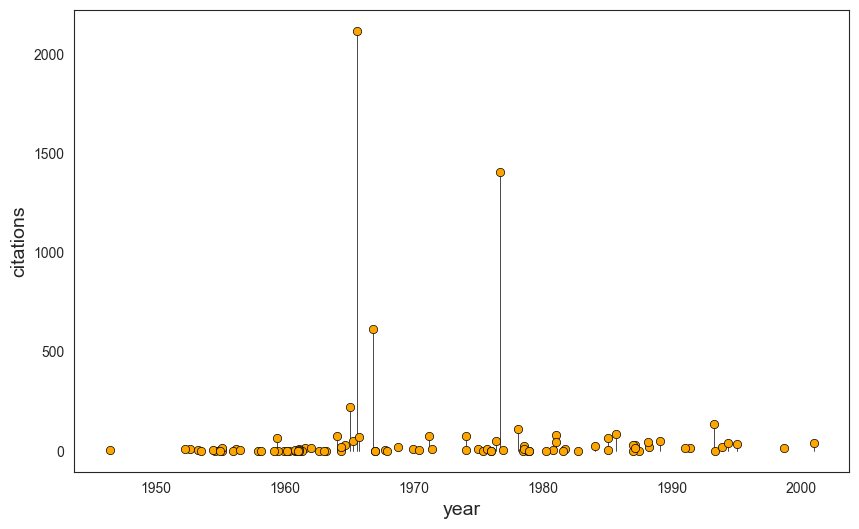

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

ax = pyscisci.career_impacttimeline(author_career, datecol='Date', impactcol='Ctotal', 
                              fill_color='orange', edge_color='k', ax=ax)

ax.set_ylabel('citations', fontsize=14)
ax.set_xlabel('year', fontsize=14)
#plt.savefig('DeSollaPriceCarrerCitations.pdf')
plt.show()

In [8]:

hindex = pyscisci.author_hindex(author_career, colgroupby='AuthorId', colcountby='Ctotal')
print(hindex)

gindex = pyscisci.author_gindex(author_career, colgroupby='AuthorId', colcountby='Ctotal')
print(gindex)

qfact = pyscisci.author_qfactor(author_career, colgroupby='AuthorId', colcountby='Ctotal')
print(qfact)


     AuthorId  AuthorIdHindex
0  2537508914              25
     AuthorId  AuthorIdGindex
0  2537508914              78
     AuthorId  AuthorIdQfactor
0  2537508914        11.309299


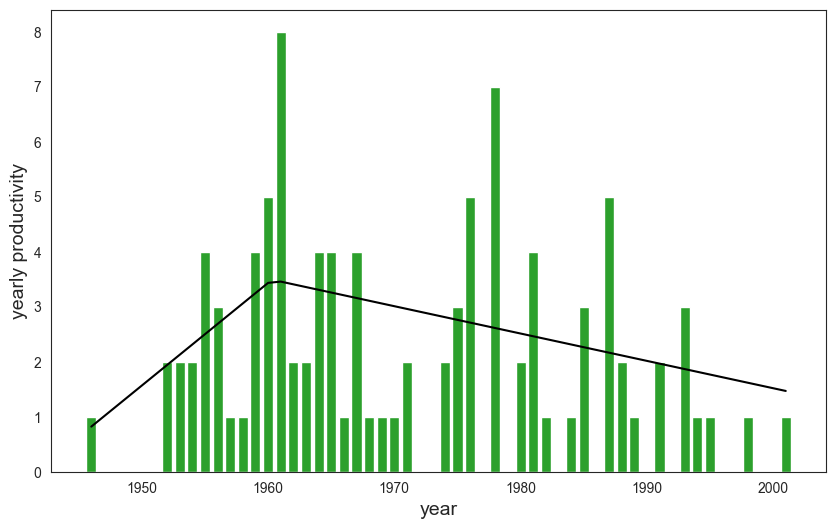

In [9]:

yearly_productivity = pyscisci.author_yearly_productivity(author_career, colgroupby='AuthorId', 
                                                          datecol='Year', colcountby='PublicationId')

prodtraj = pyscisci.author_productivity_trajectory(author_career, colgroupby = 'AuthorId', 
                                        datecol = 'Year', colcountby = 'PublicationId')

fig, ax = plt.subplots(1,1,figsize=(10,6))

ax = pyscisci.career_productivitytimeline(yearly_productivity, productivity_trajectory=prodtraj, 
                                          datecol='Year', fill_color=sns.color_palette()[2], ax=ax)

ax.set_ylabel('yearly productivity', fontsize=14)
ax.set_xlabel('year', fontsize=14)
plt.show()

# Career HotStreak

In [5]:
author_career_streak = author_career[author_career['C10'] > 0].reset_index(drop=True)
pyscisci.career_hotstreak(author_career_streak, citecol='C10')

,Baseline,StreakGamma,StreakStart,StreakEnd
0,0.719092,None,None,None


In [12]:
# This example does not have a hot streak so only the baseline is filled without a start/end index
pyscisci.author_hotstreak(author_career_streak, colgroupby='AuthorId', datecol='Date', citecol='C10')

,AuthorId,StreakNumber,Baseline,StreakGamma,StreakStart,StreakEnd
0,2537508914,0,0.720276,None,None,None
